# Automated 2D Branch Angle Estimator

The functions in this notebook are able to take a .jpg of a blank piece of paper with Arabidopsis branches on them, all with their bases (root-end) pointing towards, and calculate their branch angles. Please run all cells and then change out the filename referenced in the last cell to change the image you are processing. Note that the image file must be in the same folder as this notebook for it to work. Also note that images of individual branches from the original image will be outputted to the folder; please double-check these to confirm the order that the branches were processed in and to diagnose any unusual looking angle estimates.

In the end, you will get an exported excel spreadsheet with your angle estimates associated with sample names, as well as a reference image 'Reference.jpg' that shows a binarized version of your original image with sample names next to each branch.

In [144]:
from imageio import imread, imsave
from matplotlib.pylab import plt
import numpy as np
from plantcv import plantcv as pcv
from imageio import imread, imsave
from matplotlib.pylab import plt
import numpy as np
import skimage
from skimage.morphology import remove_small_objects
import matplotlib.colors as colors
from imageio import imread, imsave
from matplotlib.pylab import plt
import numpy as np
from scipy.ndimage.measurements import label
from scipy.ndimage.measurements import find_objects
Import PIL
from PIL import Image
from PIL import ImageDraw
from matplotlib import cm
import math
import pandas as pd


In [140]:
def identify_branches_modified(filename):
    
    '''
    Takes a filename and outputs cropped binary images, each corresponding to one branch
    in the original image
    
    inputs
    
    filename: The name of the file you're processing as a string, e.g. "test.jpg"
    
    outputs
    
    branches: numpy arrays describing each branch for use in downstream functions
    '''
    
    #color segmentation to extract stems from background
    
    branches = []
    im = imread(filename)

    rmin = -1
    rmax = 256
    gmin = -1
    gmax = 200
    bmin = -1
    bmax = 256

    r = im[:,:,0]; #red
    g = im[:,:,1]; #green
    b = im[:,:,2]; #blue

    if rmin > rmax:
        b_img = (r > rmin) | (r < rmax)
    else:
        b_img = (r > rmin) & (r < rmax);
    b_img = (b_img & 
        (g > gmin) & (g < gmax) & 
        (b > bmin) & (b < bmax));

    b_img_cleaned = remove_small_objects(b_img,min_size=500) #removing small artifacts

    labeled_array, num_features = label(b_img_cleaned) #labeling the individual branches
    
    temporary_filename = 'tempFile.jpg'
    
    imsave(temporary_filename,labeled_array)
    img_to_label = Image.open('tempFile.jpg')     
    draw = PIL.ImageDraw.Draw(img_to_label)
    for i in range(num_features):
        found = False
        for j in range(labeled_array.shape[0]):
            for k in range(labeled_array.shape[1]):
                to_check = i + 1
                if labeled_array[j,k] == to_check:
                    draw.text((k,j),text='Sample_{0}'.format(i),fill='green')
                    found = True
                    break
            if found:
                break
    
    img_to_label.save('Reference.jpg'.format(filename))
    
    objects = []

    for i in range(1000): #finding how many there are and putting them in a list
        try: 
            objects.append(find_objects(labeled_array)[i])
        except:
            break

    slices = []

    for i in range(len(objects)):
        slices.append(labeled_array[objects[i]]) # extracting slices from these objects

    fig, ax = plt.subplots(len(slices),1,figsize=(7,10))    #plotting all of them

    for i in range(len(slices)):
        ax[i].imshow(slices[i])
    
    for i in range(len(slices)): # adding a little buffer to the edges for skeletonization and branchpoint finding
    
        transientFilename = '{0}_branch_{1}.jpg'.format(filename,i)
        imsave(transientFilename,slices[i])

        old_im = Image.open(transientFilename)
        old_size = old_im.size

        new_size = (int(old_im.size[0]*1.2), int(old_im.size[1]*1.2))
        new_im = Image.new('1', new_size)   ## luckily, this is already black!
        new_im.paste(old_im, ((new_size[0]-old_size[0])//2,
                              (new_size[1]-old_size[1])//2))

        new_im.save("out.png")
        im = imread("out.png") # reading back in so we get a nice numpy array
        branches.append(im) #adding to our output
    
    return branches

In [3]:
def retrieve_points(images):
    
    '''
    Skeletonizes each cropped image from identify_branches() and returns
    the branch_point and tip_point masks
    
    input
    images: A list of images, in the form of arrays, outputted by identify_branches
    
    outputs
    
    branch_points: Masks that show the locations of branch points in each input image
    tip_points: Masks that show the locations of tip points in each input image
    '''
    
    branch_points = []
    tip_points = []
    for i in range(len(images)):
        skeleton = pcv.morphology.skeletonize(images[i])
        branch_pts_mask = pcv.morphology.find_branch_pts(skel_img=skeleton,mask=None, label="default")
        tip_pts_mask = pcv.morphology.find_tips(skel_img=skeleton, mask=None, label="default")
        
        branch_points.append(branch_pts_mask)
        tip_points.append(tip_pts_mask)
    return branch_points, tip_points

In [4]:
def indexer(array):
    
    '''
    Given a mask, returns coordinates of points
    
    input:
    array: any array where 'points' are denoted by the number 255
    
    ouputs:
    coords: a list of xy coordinates of the identified points
    '''
    
    to_process = np.where(array == 255)
    ys = to_process[0]
    xs = to_process[1]
    coords = []
    for i in range(len(xs)):
        coord = [xs[i],ys[i]]
        coords.append(coord)
    return coords

In [5]:
## find base

def find_base(tips):
    
    '''
    From a set of points, identifies the 'bottom-most' one based on y coordinates
    
    input:
    tips: A set of tip points
    output: 
    to_return: the point that corresponds to the base
    '''
    
    y_coordinates = []
    for i in range(len(tips)):
        y_coordinates.append(tips[i][1])
    max_index = np.argmax(y_coordinates)
    to_return = tips[max_index]
    return to_return

In [6]:
## find branchpoint with smallest euclidian distance to base

def find_branch_point(array,base):
    
    '''
    Identifies the branch point that is closest to the provided base
    
    input: 
    array: A branch point mask from retrieve_points()
    base: the base point coordinates from find_base()
    
    output: 
    branch_point_coord: the coordinates of the branch point
    
    '''
    to_process = np.where(array == 255)
    ys = to_process[0]
    xs = to_process[1]
    coords = []
    for i in range(len(xs)):
        coord = [xs[i],ys[i]]
        coords.append(coord)
    coords_to_use = []
    for i in range(len(coords)):
        if coords[i] != base:
            coords_to_use.append(coords[i])
    distances = []
    for i in range(len(coords_to_use)):
        distance = math.sqrt((coords_to_use[i][0] - base[0])**2 + (coords_to_use[i][1] - base[1])**2)
        distances.append(distance)
    branch_point_index = np.argmin(distances)
    branch_point_coord = coords_to_use[branch_point_index]        
    return branch_point_coord

In [7]:
# I've got the relevant branch point + the relevant base. Now, find the two tips farthest from the branch point. 

def find_branch_tips(array,branch_point,base):
    '''
    Given a tip point mask, the branch point, and the base, finds the tip points
    that are furthest from the branch point, not including the base
    
    inputs:
    array: a tip point mask from retrieve_points()
    base: the base point coordinates from find_base()
    branch_point: the branch point coordinates from find_branch_point
    
    '''
    
    to_process = np.where(array == 255)
    ys = to_process[0]
    xs = to_process[1]
    coords = []
    for i in range(len(xs)):
        coord = [xs[i],ys[i]]
        coords.append(coord)
    coords_to_use = []
    for i in range(len(coords)):
        if coords[i] != base:
            coords_to_use.append(coords[i])
    
    # calculate distances of remaining tips to the branch point
    distances = []
    for i in range(len(coords_to_use)):
        distance = math.sqrt((coords_to_use[i][0] - branch_point[0])**2 + (coords_to_use[i][1] - branch_point[1])**2)
        distances.append(distance)
    original_distances = distances
    distances.sort()
    first = distances[0]
    second = distances[1]
    top_index = original_distances.index(first)
    second_index = original_distances.index(second)
    
    branch_tips = [coords_to_use[top_index],coords_to_use[second_index]]
    return branch_tips

In [8]:
# now we've got the base, our branch point, and our two things to compare against. Now
# (1) branchpoint to branch tip 1, and branchpoint to branch tip 2 vectors
# (2) Figure out the angle between them

def branch_angle(branch_tips,branch_point):
    '''
    Given the branch tips and the branch point coordinates, creates
    vectors describing both branches from the branch point and calculates
    the angles between them
    
    inputs:
    branch_tips: coordinates for the branch tip points from find_branch_tips()
    branch_point: coordinates for the branch point from find_branch_point()
    
    output:
    angle_in_degrees: the angle between the two branch vectors in degrees
    '''
    
    first_branch_tip = branch_tips[0]
    second_branch_tip = branch_tips[1]
    branch_vector_one = [first_branch_tip[0] - branch_point[0],first_branch_tip[1] - branch_point[1]]
    branch_vector_two = [second_branch_tip[0] - branch_point[0],second_branch_tip[1] - branch_point[1]]
    
    unit_vector_1 = branch_vector_one / np.linalg.norm(branch_vector_one)
    unit_vector_2 = branch_vector_two / np.linalg.norm(branch_vector_two)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle_in_radians = np.arccos(dot_product)
    angle_in_degrees = np.degrees(angle_in_radians)
    
    return angle_in_degrees


In [9]:
## Put everything together into one function

def calculate_branch_angle(tip_pts_mask,branch_pts_mask):
    
    '''
    A function combining earlier functions to go from the tip_pts_mask and
    branch_pts_mask from retrieve_points all the way to returning a branch
    angle
    '''
    indices = indexer(tip_pts_mask)
    base = find_base(indices)
    branch_point = find_branch_point(branch_pts_mask,base)
    branch_tips = find_branch_tips(tip_pts_mask,branch_point,base)
    degrees = branch_angle(branch_tips,branch_point)
    return degrees

In [10]:
def calculate_all_angles(branch_points,tip_points):
    
    '''
    Given the branch and tip locations from retrieve_points(), calculates
    the branch angles for each branch in the original image
    
    inputs
    branch_points: Masks that show the location of branch points
    tip_points: Masks that show the locations of tip points
    
    output
    
    all_angles: A list of all branch angles from the input points
    
    '''
    
    all_angles = []
    for i in range(len(branch_points)):
        angle = calculate_branch_angle(tip_points[i],branch_points[i])
        all_angles.append(angle)
    return all_angles

In [137]:
def get_angles(filename):
    branches = identify_branches_modified(filename)
    branch_points, tip_points = retrieve_points(branches)
    results = calculate_all_angles(branch_points,tip_points)
    return results

# Code to run for angle estimation

Lossy conversion from int32 to uint8. Range [0, 7]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 3]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 4]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 6]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 7]. Convert image to uint8 prior to saving to suppress this warning.


Your angles are:
Sample_0 :  8.49795317919213
Sample_1 :  33.18445435732822
Sample_2 :  36.43584701370462
Sample_3 :  76.42956561483852
Sample_4 :  21.07952552203864
Sample_5 :  32.05152037245762
Sample_6 :  36.53642125193937


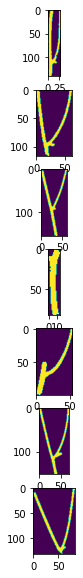

In [143]:
filename = 'just_branches.jpg' # put your filename here
angles = get_angles(filename)
sample_names = []
for i in range(len(angles)):
    sample_names.append('Sample_{0}'.format(i))
print('Your angles are:')
for i in range(len(sample_names)):
    print(sample_names[i],': ',angles[i])

to_convert = {'Samples':sample_names,'Angles':angles}
to_export = pd.DataFrame(to_convert)
to_export.to_excel('Exported_Angles.xlsx')